In [0]:
import tensorflow as tf
if tf.__version__ != '2.0.0-rc1':
  !pip install tensorflow-gpu==2.0.0-rc1
  !pip install tensorflow_probability==0.8.0-rc0
  !pip install numpy==1.17.2

  import os
  os.kill(os.getpid(), 9)

from load import sort_and_order, skip_row, read_3d, skip_row, transform, fit_scale, roll, sort_links, tod_interval, split_df_with_val, tilted_loss_np_t
from models import convLstm, joint_convLstm, joint_tilted_loss, tilted_loss, mse_loss

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import math
from datetime import datetime
tfd = tfp.distributions
tfb = tfp.bijectors
import pandas as pd
import csv
import seaborn as sns; sns.set()

## Prediction Using Pre-trained Weights (Input Timestep Lag 10)
The weights trained in grid_search.py have been saved, we will now predict on three partitions of data (train on 4 weeks, evaluate on the following week). 

In [0]:
units_lst = np.arange(6, 70, 12)
kernel_lengths = np.arange(3, 14, 2)

for u, units in enumerate(units_lst):
  for k, kern in enumerate(kernel_lengths):
    for part in range(3):
      try:
        f = open('weights/mean_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))
      except:
        print('weights/mean_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))

      try:
        f = open('weights/q0_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))
      except:
        print('weights/q0_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))

      try:
        f = open('weights/q1_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))
      except:
        print('weights/q1_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))

      try:
        f = open('weights/joint_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))
      except:
        print('weights/joint_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))

In [0]:
quantiles = np.array([0.05, 0.95])
units_lst = np.arange(6, 70, 12)
kernel_lengths = np.arange(3, 14, 2)
num_links = 16

lags = 10
preds = 1
quantiles = np.array([0.05, 0.95])

num_partitions = 3
start_train_lst = ['2019-01-01', '2019-01-07', '2019-01-14', '2019-01-21', '2019-02-01']
end_train_lst = ['2019-01-31', '2019-02-07', '2019-02-14', '2019-02-21', '2019-03-01']
end_test_lst = ['2019-02-07', '2019-02-14', '2019-02-21', '2019-03-01', '2019-03-07']

mse_i_l10 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))
icp_i_l10 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))
mil_i_l10 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))

mse_j_l10 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))
icp_j_l10 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))
mil_j_l10 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))

for u, units in enumerate(units_lst):
  print("Units {}".format(units))
  for k, kern in enumerate(kernel_lengths):
    print("   Kernel length {}".format(kern), end = '')
    ## Initialise models
    ## Model for mean predictions
    mod_mean = convLstm(units,kern,lags, num_links,1, loss = lambda y, f: mse_loss(y,f))
		
		## Models for quantiles
    mod_q1 = convLstm(units,kern,lags,  num_links, 1, loss = lambda y, f: tilted_loss(quantiles[0], y, f))
    mod_q2 = convLstm(units,kern,lags,  num_links, 1, loss = lambda y, f: tilted_loss(quantiles[1], y, f))
    
		## Joint model
    mod_joint = joint_convLstm(units, kern,lags, num_links, 1, quantiles, loss = lambda y, f: joint_tilted_loss(quantiles, y, f))
    
    print("      Partition ", end = '')
    for part in range(num_partitions):
      print("{}".format(part+1), end = '')
      start_train = start_train_lst[part]
      end_train = end_train_lst[part]
      end_test = end_test_lst[part]
      ts_train_df, mean_train_df, scale_train_df, ts_test_df, mean_test_df, scale_test_df = load_data(lags, start_train, end_train, end_test)

      X_train, y_train, y_ix_train, y_mean_train, y_std_train = roll(ts_train_df.index, 
                                                                      ts_train_df.values,
                                                                      mean_train_df.values,
                                                                      scale_train_df.values,
                                                                      lags, 
                                                                      preds)
      X_test, y_test, y_ix_test, y_mean_test, y_std_test = roll(ts_test_df.index, 
                                                                ts_test_df.values, 
                                                                mean_test_df.values,
                                                                scale_test_df.values,
                                                                lags, 
                                                                preds)
      X_train = X_train[:,:,:,np.newaxis,np.newaxis]
      y_train = y_train[:,:,:,np.newaxis,np.newaxis]
      X_test = X_test[:,:,:,np.newaxis,np.newaxis]
      y_test = y_test[:,:,:,np.newaxis,np.newaxis]
      
      y_traink = np.zeros((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
      y_testk  = np.zeros((y_test.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
      for i in range(len(quantiles)):
        y_traink[:,:,:,:,i+1] = y_train[:,:,:,:,0]
        y_testk[:,:,:,:,i+1] = y_test[:,:,:,:,0]
      
      ## Load pre-trained weights
      mod_mean.load_weights('weights/mean_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))
      mod_q1.load_weights('weights/q0_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))
      mod_q2.load_weights('weights/q1_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))
      mod_joint.load_weights('weights/joint_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))

      ################### INDEPENDENT ############################
      y_pred = mod_mean.predict(X_test)
      print(".", end = '')
      y_pred_q1 = mod_q1.predict(X_test)
      print(".", end = '')
      y_pred_q2 = mod_q2.predict(X_test)
      print(".", end = '')
      Y_pred_lwr  = y_pred_q1[:,:,:,0,0]
      Y_pred_upr  = y_pred_q2[:,:,:,0,0]
      Y_pred_mean = y_pred[:,:,:,0,0]
      Y_true = y_test[:,:,:,0,0]
      
      Y_true_total = np.sum(Y_true, axis = 2)
      Y_pred_mean_total = np.sum(Y_pred_mean, axis = 2)
      q1_total = np.sum(Y_pred_lwr, axis = 2)
      q2_total = np.sum(Y_pred_upr, axis = 2)

      icp_lnks = np.zeros(num_links)
      mil_lnks = np.zeros(num_links) 
      for lnk in range(num_links):
            q1 = Y_pred_lwr[:,:,lnk]
            q2 = Y_pred_upr[:,:,lnk]
            icp_lnks[lnk] = 1 - (np.sum(Y_true[:,:,lnk] < q1) + np.sum(Y_true[:,:,lnk] > q2) )/len(y_test)
            mil_lnks[lnk] = np.sum(np.maximum(0, q2 - q1)) / len(y_test)
      icp_i_l10[part, u, k] = np.mean(icp_lnks)
      mil_i_l10[part, u, k] = np.mean(mil_lnks)
      mse_i_l10[part,  u, k] = np.sum((Y_pred_mean_total - Y_true_total)**2)/len(Y_true_total)
      
      #################### JDQR MODEL #####################
      y_pred = mod_joint.predict(X_test)
      print(". ", end = '')
      Y_true = y_test[:,:,:,0,0]
      Y_pred_mean = y_pred[:,:,:,0,0]
      Y_pred_lwr  = y_pred[:,:,:,0,1]
      Y_pred_upr  = y_pred[:,:,:,0,2]
    
      Y_true_total = np.sum(Y_true , axis = 2)
      Y_pred_mean_total = np.sum(Y_pred_mean, axis = 2)

      icp_lnks = np.zeros(num_links)
      mil_lnks = np.zeros(num_links)  
      for lnk in range(num_links):
            q1 = Y_pred_lwr[:,:,lnk]
            q2 = Y_pred_upr[:,:,lnk]
            icp_lnks[lnk] = 1 - (np.sum(Y_true[:,:,lnk] < q1) + np.sum(Y_true[:,:,lnk] > q2) )/len(y_test)
            mil_lnks[lnk] = np.sum(np.maximum(0, q2 - q1)) / len(y_test)

      icp_j_l10[part, u, k] = np.mean(icp_lnks)
      mil_j_l10[part, u, k] = np.mean(mil_lnks)
      mse_j_l10[part, u, k] = np.sum((Y_pred_mean_total - Y_true_total)**2)/len(Y_true_total)
    print("\n")

Units 6
   Kernel length 3      Partition 1.... 2.... 3.... 

   Kernel length 5      Partition 1.... 2.... 3.... 

   Kernel length 7      Partition 1.... 2.... 3.... 

   Kernel length 9      Partition 1.... 2.... 3.... 

   Kernel length 11      Partition 1.... 2.... 3.... 

   Kernel length 13      Partition 1.... 2.... 3.... 

Units 18
   Kernel length 3      Partition 1.... 2.... 3.... 

   Kernel length 5      Partition 1.... 2.... 3.... 

   Kernel length 7      Partition 1.... 2.... 3.... 

   Kernel length 9      Partition 1.... 2.... 3.... 

   Kernel length 11      Partition 1.... 2.... 3.... 

   Kernel length 13      Partition 1.... 2.... 3.... 

Units 30
   Kernel length 3      Partition 1.... 2.... 3.... 

   Kernel length 5      Partition 1.... 2.... 3.... 

   Kernel length 7      Partition 1.... 2.... 3.... 

   Kernel length 9      Partition 1.... 2.... 3.... 

   Kernel length 11      Partition 1.... 2.... 3.... 

   Kernel length 13      Partition 1.... 2.... 3...

## Assessing Model Error
We will now visualise the grid errors using heatmaps

In [0]:
tradeoff_i_l10 = np.abs(icp_i - 0.90)*mil_i
tradeoff_j_l10 = np.abs(icp_j - 0.90)*mil_j

[]

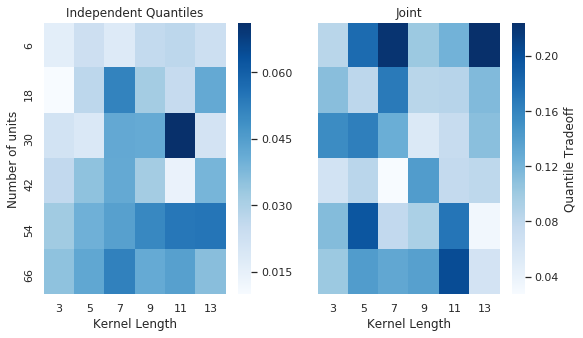

In [0]:
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(9, 5), gridspec_kw={'width_ratios':[1.7,1.7]})
ax1.get_shared_y_axes().join(ax2)
sns.heatmap(np.mean(tradeoff_i_l10, axis=0), cmap = "Blues", 
            ax=ax1, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax1.set_ylabel('Number of units')
ax1.set_xlabel('Kernel Length')
ax1.set_title('Independent Quantiles')
sns.heatmap(np.mean(tradeoff_j_l10[1:], axis=0), cmap = "Blues",  
            ax=ax2, yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'Quantile Tradeoff'})
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)
ax2.set_xlabel('Kernel Length')
ax2.set_title('Joint')
ax2.set_yticks([])

[]

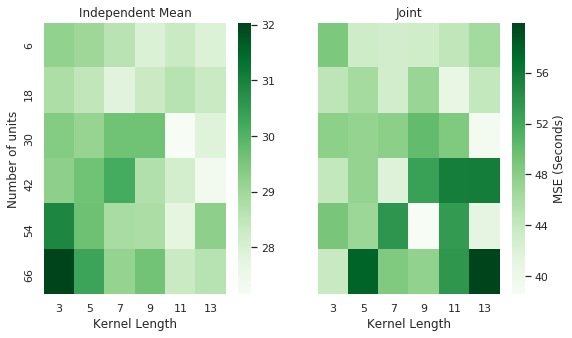

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), gridspec_kw={'width_ratios':[1.7,1.7]})
ax1.get_shared_y_axes().join(ax2)
sns.heatmap(np.mean(mse_i,axis=0), cmap = "Greens", 
            ax=ax1, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax1.set_ylabel('Number of units')
ax1.set_xlabel('Kernel Length')
ax1.set_title('Independent Mean')
sns.heatmap(np.mean(mse_j, axis=0), cmap = "Greens", 
            ax=ax2, yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'MSE (Seconds)'})
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)
ax2.set_xlabel('Kernel Length')
ax2.set_title('Joint')
ax2.set_yticks([])

In [0]:
time_mean = read_3d('DQR/run times/time_mean')
time_quan = read_3d('DQR/run times/time_quan')
time_joint = read_3d('DQR/run times/time_joint')

[]

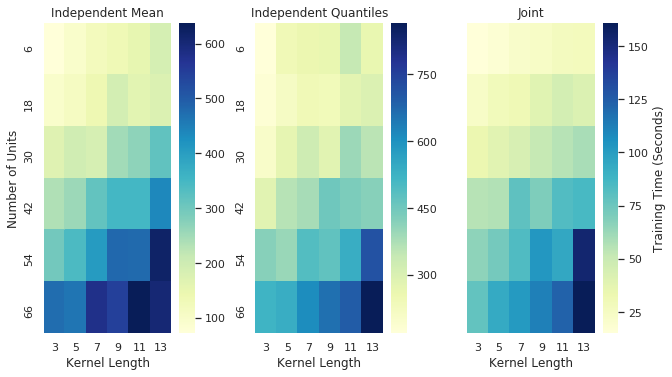

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 5), gridspec_kw={'width_ratios':[2.7,2.7,2.7]})
f.tight_layout()
ax1.get_shared_y_axes().join(ax2, ax2)
sns.heatmap(time_mean[0], cmap="YlGnBu", ax=ax1, 
            yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax1.set_ylabel('Number of Units')
ax1.set_xlabel('Kernel Length')
ax1.set_title('Independent Mean')
sns.heatmap(time_quan[0], cmap="YlGnBu", ax=ax2, 
            yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)
ax2.set_xlabel('Kernel Length')
ax2.set_title('Independent Quantiles')
ax2.set_yticks([])
sns.heatmap(time_joint[0], ax=ax3, cmap="YlGnBu", 
            yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'Training Time (Seconds)'})
bottom, top = ax3.get_ylim()
ax3.set_ylim(bottom + 0.5, top - 0.5)
ax3.set_xlabel('Kernel Length')
ax3.set_title('Joint')
ax3.set_yticks([])

[]

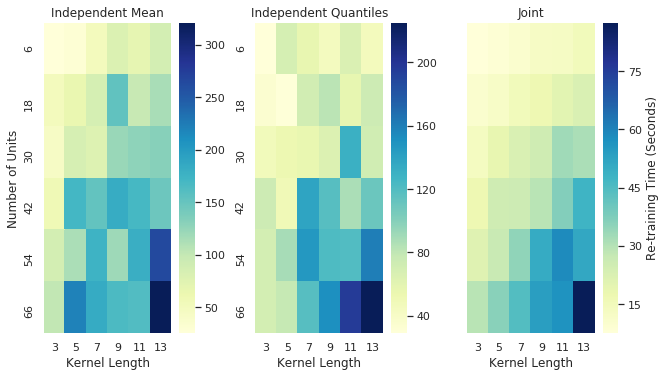

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 5), gridspec_kw={'width_ratios':[2.7,2.7,2.7]})
f.tight_layout()
ax1.get_shared_y_axes().join(ax2, ax2)
sns.heatmap(np.mean(time_mean[1:], axis=0), cmap="YlGnBu", ax=ax1, 
            yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax1.set_ylabel('Number of Units')
ax1.set_xlabel('Kernel Length')
ax1.set_title('Independent Mean')
sns.heatmap(np.mean(time_quan[1:], axis=0), cmap="YlGnBu", ax=ax2, 
            yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)
ax2.set_xlabel('Kernel Length')
ax2.set_title('Independent Quantiles')
sns.heatmap(np.mean(time_joint[1:], axis=0), ax=ax3, cmap="YlGnBu", 
            yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'Re-training Time (Seconds)'})
bottom, top = ax3.get_ylim()
ax3.set_ylim(bottom + 0.5, top - 0.5)
ax3.set_xlabel('Kernel Length')
ax3.set_title('Joint')
ax3.set_yticks([])

For the independent mean:
 - Retrain time is high for units greater than 18 and kernel lengths greater than 5.
 - Train time is high for units greater than 18 (any kernel length)
 - MSE is lowest for kernel lenghts **11-13**

For the independent quantiles:
 - Low units (6-18) result in low training and retraining times. 
 - Tradeoff is lowest in the area with **6-30** units and **3-5** kernel lenghts


For the joint:
 - (Mean) Upper left triangle is mostly fine
 - (Quantiles) Units 18-30 kernel lengths 9-13 is lowest area. Best intercept is units = 18, kernel lengths = 9

## Prediction Using Pre-trained Weights (Input Timestep Lag 32)

In [0]:
quantiles = np.array([0.05, 0.95])
units_lst = np.arange(6, 70, 12)
kernel_lengths = np.arange(3, 14, 2)
num_links = 16

lags = 32
preds = 1
quantiles = np.array([0.05, 0.95])

num_partitions = 3
start_train_lst = ['2019-01-01', '2019-01-07', '2019-01-14', '2019-01-21', '2019-02-01']
end_train_lst = ['2019-01-31', '2019-02-07', '2019-02-14', '2019-02-21', '2019-03-01']
end_test_lst = ['2019-02-07', '2019-02-14', '2019-02-21', '2019-03-01', '2019-03-07']

#mse_i_l32 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))
#icp_i_l32 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))
#mil_i_l32 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))

#mse_j_l32 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))
#icp_j_l32 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))
#mil_j_l32 =  np.empty((num_partitions, len(units_lst), len(kernel_lengths)))

for u, units in enumerate(units_lst):
  print("Units {}".format(units))
  for k, kern in enumerate(kernel_lengths):
    print("   Kernel length {}".format(kern), end = '')
    ## Initialise models
    ## Model for mean predictions
    mod_mean = convLstm(units,kern,lags, num_links,1, loss = lambda y, f: mse_loss(y,f))
		
		## Models for quantiles
    mod_q1 = convLstm(units,kern,lags,  num_links, 1, loss = lambda y, f: tilted_loss(quantiles[0], y, f))
    mod_q2 = convLstm(units,kern,lags,  num_links, 1, loss = lambda y, f: tilted_loss(quantiles[1], y, f))
    
		## Joint model
    mod_joint = joint_convLstm(units, kern,lags, num_links, 1, quantiles, loss = lambda y, f: joint_tilted_loss(quantiles, y, f))
    
    print("      Partition ", end = '')
    for part in range(num_partitions):
      print("{}".format(part+1), end = '')
      start_train = start_train_lst[part]
      end_train = end_train_lst[part]
      end_test = end_test_lst[part]
      ts_train_df, mean_train_df, scale_train_df, ts_test_df, mean_test_df, scale_test_df = load_data(lags, start_train, end_train, end_test)

      X_train, y_train, y_ix_train, y_mean_train, y_std_train = roll(ts_train_df.index, 
                                                                      ts_train_df.values,
                                                                      mean_train_df.values,
                                                                      scale_train_df.values,
                                                                      lags, 
                                                                      preds)
      X_test, y_test, y_ix_test, y_mean_test, y_std_test = roll(ts_test_df.index, 
                                                                ts_test_df.values, 
                                                                mean_test_df.values,
                                                                scale_test_df.values,
                                                                lags, 
                                                                preds)
      X_train = X_train[:,:,:,np.newaxis,np.newaxis]
      y_train = y_train[:,:,:,np.newaxis,np.newaxis]
      X_test = X_test[:,:,:,np.newaxis,np.newaxis]
      y_test = y_test[:,:,:,np.newaxis,np.newaxis]
      
      y_traink = np.zeros((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
      y_testk  = np.zeros((y_test.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
      for i in range(len(quantiles)):
        y_traink[:,:,:,:,i+1] = y_train[:,:,:,:,0]
        y_testk[:,:,:,:,i+1] = y_test[:,:,:,:,0]
      
      ## Load pre-trained weights
      mod_mean.load_weights('DQR/weights/mean_weights_l{}_a{}_k{}_p{}.hdf5'.format(lags, units, kern, part))
      mod_q1.load_weights('DQR/weights/q0_weights_l{}_a{}_k{}_p{}.hdf5'.format(lags, units, kern, part))
      mod_q2.load_weights('DQR/weights/q1_weights_l{}_a{}_k{}_p{}.hdf5'.format(lags, units, kern, part))
      mod_joint.load_weights('DQR/weights/joint_weights_l{}_a{}_k{}_p{}.hdf5'.format(lags, units, kern, part))

      ################### INDEPENDENT ############################
      y_pred = mod_mean.predict(X_test)
      print(".", end = '')
      y_pred_q1 = mod_q1.predict(X_test)
      print(".", end = '')
      y_pred_q2 = mod_q2.predict(X_test)
      print(".", end = '')
      Y_pred_lwr  = y_pred_q1[:,:,:,0,0]
      Y_pred_upr  = y_pred_q2[:,:,:,0,0]
      Y_pred_mean = y_pred[:,:,:,0,0]
      Y_true = y_test[:,:,:,0,0]
      
      Y_true_total = np.sum(Y_true, axis = 2)
      Y_pred_mean_total = np.sum(Y_pred_mean, axis = 2)
      q1_total = np.sum(Y_pred_lwr, axis = 2)
      q2_total = np.sum(Y_pred_upr, axis = 2)

      icp_lnks = np.zeros(num_links)
      mil_lnks = np.zeros(num_links) 
      for lnk in range(num_links):
            q1 = Y_pred_lwr[:,:,lnk]
            q2 = Y_pred_upr[:,:,lnk]
            icp_lnks[lnk] = 1 - (np.sum(Y_true[:,:,lnk] < q1) + np.sum(Y_true[:,:,lnk] > q2) )/len(y_test)
            mil_lnks[lnk] = np.sum(np.maximum(0, q2 - q1)) / len(y_test)
      icp_i_l32[part, u, k] = np.mean(icp_lnks)
      mil_i_l32[part, u, k] = np.mean(mil_lnks)
      mse_i_l32[part,  u, k] = np.sum((Y_pred_mean_total - Y_true_total)**2)/len(Y_true_total)
      
      #################### JDQR MODEL #####################
      y_pred = mod_joint.predict(X_test)
      print(". ", end = '')
      Y_true = y_test[:,:,:,0,0]
      Y_pred_mean = y_pred[:,:,:,0,0]
      Y_pred_lwr  = y_pred[:,:,:,0,1]
      Y_pred_upr  = y_pred[:,:,:,0,2]
    
      Y_true_total = np.sum(Y_true , axis = 2)
      Y_pred_mean_total = np.sum(Y_pred_mean, axis = 2)

      icp_lnks = np.zeros(num_links)
      mil_lnks = np.zeros(num_links)  
      for lnk in range(num_links):
            q1 = Y_pred_lwr[:,:,lnk]
            q2 = Y_pred_upr[:,:,lnk]
            icp_lnks[lnk] = 1 - (np.sum(Y_true[:,:,lnk] < q1) + np.sum(Y_true[:,:,lnk] > q2) )/len(y_test)
            mil_lnks[lnk] = np.sum(np.maximum(0, q2 - q1)) / len(y_test)

      icp_j_l32[part, u, k] = np.mean(icp_lnks)
      mil_j_l32[part, u, k] = np.mean(mil_lnks)
      mse_j_l32[part, u, k] = np.sum((Y_pred_mean_total - Y_true_total)**2)/len(Y_true_total)
    print("\n")

Units 6
   Kernel length 3      Partition 1.... 2.... 3.... 

   Kernel length 5      Partition 1.... 2.... 3.... 

   Kernel length 7      Partition 1.... 2.... 3.... 

   Kernel length 9      Partition 1.... 2.... 3.... 

   Kernel length 11      Partition 1.... 2.... 3.... 

   Kernel length 13      Partition 1.... 2.... 3.... 

Units 18
   Kernel length 3      Partition 1.... 2.... 3.... 

   Kernel length 5      Partition 1.... 2.... 3.... 

   Kernel length 7      Partition 1.... 2.... 3.... 

   Kernel length 9      Partition 1.... 2.... 3.... 

   Kernel length 11      Partition 1.... 2.... 3.... 

   Kernel length 13      Partition 1.... 2.... 3.... 

Units 30
   Kernel length 3      Partition 1.... 2.... 3.... 

   Kernel length 5      Partition 1.... 2.... 3.... 

   Kernel length 7      Partition 1.... 2.... 3.... 

   Kernel length 9      Partition 1.... 2.... 3.... 

   Kernel length 11      Partition 1.... 2.... 3.... 

   Kernel length 13      Partition 1.... 2.... 3...

In [0]:
tradeoff_i_l10 = np.abs(icp_i_l10 - 0.90)*mil_i_l10
tradeoff_j_l10 = np.abs(icp_j_l10 - 0.90)*mil_j_l10
tradeoff_i_l32 = np.abs(icp_i_l32 - 0.90)*mil_i_l32
tradeoff_j_l32 = np.abs(icp_j_l32 - 0.90)*mil_j_l32

# Quantile Trade-off Heatmaps

Text(0.95, 0.3, 'Lag 32')

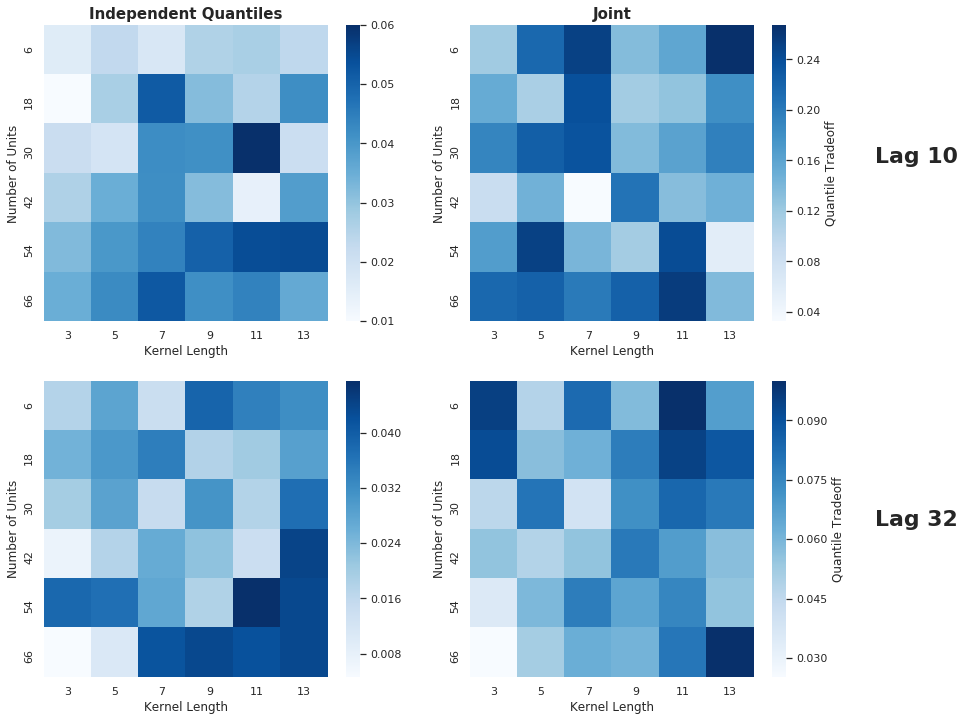

In [0]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12), gridspec_kw={'width_ratios':[1.7,1.7]})
ax1.get_shared_y_axes().join(ax2)
sns.heatmap(np.mean(tradeoff_i_l10, axis=0), vmax=6e-2,cmap = "Blues", 
            ax=ax1, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax1.set_ylabel('Number of Units')
ax1.set_xlabel('Kernel Length')
ax1.set_title('Independent Quantiles', fontdict = {'family':'normal','weight':'bold','size':15})
sns.heatmap(np.mean(tradeoff_j_l10, axis=0), cmap = "Blues",  
            ax=ax2, yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'Quantile Tradeoff'})
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)
ax2.set_xlabel('Kernel Length')
ax2.set_ylabel('Number of Units')
ax2.set_title('Joint', fontdict = {'family':'normal','weight':'bold','size':15})
#ax2.set_yticks([])

ax3.get_shared_y_axes().join(ax4)
sns.heatmap(np.mean(tradeoff_i_l32, axis=0), cmap = "Blues", 
            ax=ax3, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax3.get_ylim()
ax3.set_ylim(bottom + 0.5, top - 0.5)
ax3.set_ylabel('Number of Units')
ax3.set_xlabel('Kernel Length')
sns.heatmap(np.mean(tradeoff_j_l32, axis=0), vmax=1e-1, cmap = "Blues",  
            ax=ax4, yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'Quantile Tradeoff'})
bottom, top = ax4.get_ylim()
ax4.set_ylim(bottom + 0.5, top - 0.5)
ax4.set_xlabel('Kernel Length')
ax4.set_ylabel('Number of Units')
#ax4.set_yticks([])
f.text(0.95, 0.72, "Lag 10", fontdict = {'family' : 'normal','weight' : 'bold','size'   : 22})
f.text(0.95, 0.30, "Lag 32", fontdict = {'family' : 'normal','weight' : 'bold','size'   : 22})

# MSE Heatmaps

In [0]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12), gridspec_kw={'width_ratios':[1.7,1.7]})
ax1.get_shared_y_axes().join(ax2)
sns.heatmap(np.mean(mse_i_l10,axis=0), cmap = "Greens", 
            ax=ax1, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax1.set_ylabel('Number of Units')
ax1.set_xlabel('Kernel Length')
ax1.set_title('Independent Mean', fontdict = {'family':'normal','weight':'bold','size':15})
sns.heatmap(np.mean(mse_j_l10[1:], axis=0), cmap = "Greens",  vmax = 50,
            ax=ax2, yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'MSE'})
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)
ax2.set_xlabel('Kernel Length')
ax2.set_ylabel('Number of Units')
ax2.set_title('Joint', fontdict = {'family':'normal','weight':'bold','size':15})

ax3.get_shared_y_axes().join(ax4)
sns.heatmap(np.mean(mse_i_l32, axis=0), cmap = "Greens", 
            ax=ax3, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax3.get_ylim()
ax3.set_ylim(bottom + 0.5, top - 0.5)
ax3.set_ylabel('Number of Units')
ax3.set_xlabel('Kernel Length')
sns.heatmap(np.mean(mse_j_l32, axis=0), cmap = "Greens", vmax = 30,  
            ax=ax4, yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'MSE'})
bottom, top = ax4.get_ylim()
ax4.set_ylim(bottom + 0.5, top - 0.5)
ax4.set_xlabel('Kernel Length')
ax4.set_ylabel('Number of Units')
f.text(0.95, 0.72, "Lag 10", fontdict = {'family' : 'normal','weight' : 'bold','size'   : 22})
f.text(0.95, 0.30, "Lag 32", fontdict = {'family' : 'normal','weight' : 'bold','size'   : 22})

NameError: ignored

# Training and Re-training Heatmaps

In [0]:
time_mean_l10 = read_3d('DQR/run times/time_mean_l10')
time_quan_l10 = read_3d('DQR/run times/time_quan_l10')
time_joint_l10 = read_3d('DQR/run times/time_joint_l10')
time_mean_l32 = read_3d('DQR/run times/time_mean_l32')
time_quan_l32 = read_3d('DQR/run times/time_quan_l32')
time_joint_l32 = read_3d('DQR/run times/time_joint_l32')

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


Text(0.95, 0.3, 'Lag 32')

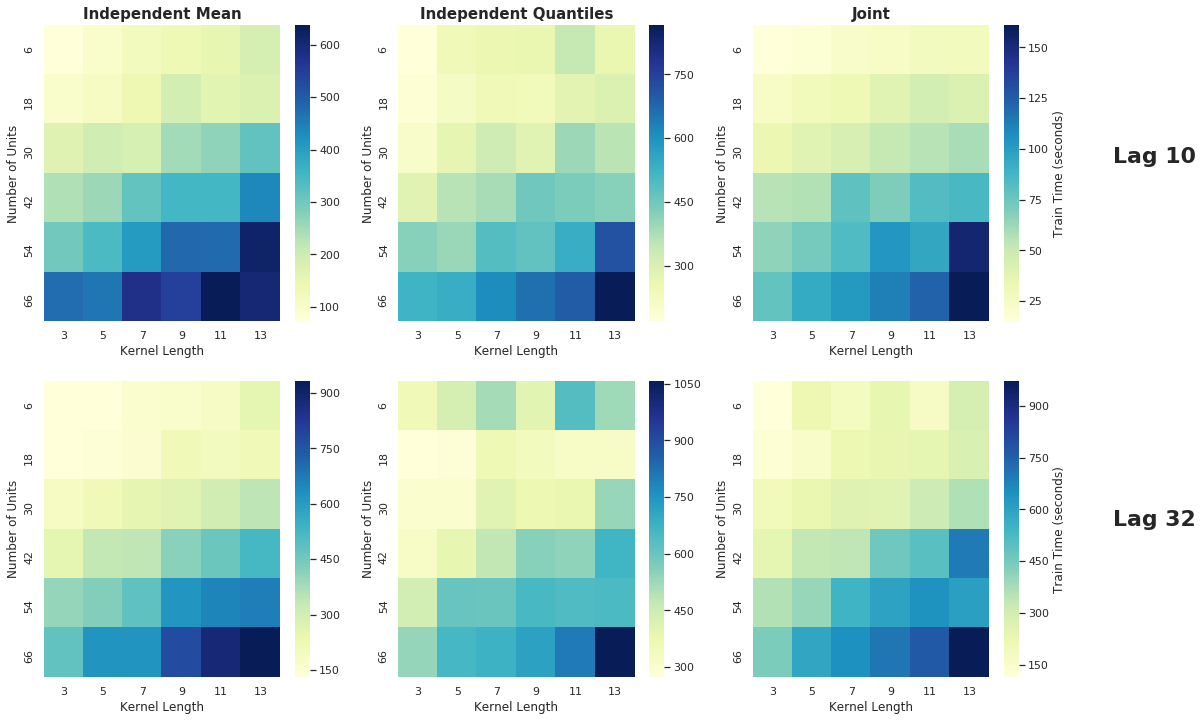

In [0]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'width_ratios':[1.7,1.7,1.7]})
ax1.get_shared_y_axes().join(ax2, ax3)
sns.heatmap(time_mean_l10[0], cmap = "YlGnBu", 
            ax=ax1, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax1.set_ylabel('Number of Units')
ax1.set_xlabel('Kernel Length')
ax1.set_title('Independent Mean', fontdict = {'family':'normal','weight':'bold','size':15})
sns.heatmap(time_quan_l10[0], cmap = "YlGnBu",  
            ax=ax2, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)
ax2.set_xlabel('Kernel Length')
ax2.set_ylabel('Number of Units')
ax2.set_title('Independent Quantiles', fontdict = {'family':'normal','weight':'bold','size':15})

sns.heatmap(time_joint_l10[0], cmap = "YlGnBu", 
            ax=ax3, yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'Train Time (seconds)'})
bottom, top = ax3.get_ylim()
ax3.set_ylim(bottom + 0.5, top - 0.5)
ax3.set_ylabel('Number of Units')
ax3.set_xlabel('Kernel Length')
ax3.set_title('Joint', fontdict = {'family':'normal','weight':'bold','size':15})

ax4.get_shared_y_axes().join(ax5, ax6)
sns.heatmap(time_mean_l32[0], cmap = "YlGnBu", 
            ax=ax4, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax4.get_ylim()
ax4.set_ylim(bottom + 0.5, top - 0.5)
ax4.set_ylabel('Number of Units')
ax4.set_xlabel('Kernel Length')
sns.heatmap(time_quan_l32[0], cmap = "YlGnBu",  
            ax=ax5, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax5.get_ylim()
ax5.set_ylim(bottom + 0.5, top - 0.5)
ax5.set_xlabel('Kernel Length')
ax5.set_ylabel('Number of Units')

ax6.get_shared_y_axes().join(ax4)
sns.heatmap(time_joint_l32[0], cmap = "YlGnBu", 
            ax=ax6, yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'Train Time (seconds)'})
bottom, top = ax6.get_ylim()
ax6.set_ylim(bottom + 0.5, top - 0.5)
ax6.set_ylabel('Number of Units')
ax6.set_xlabel('Kernel Length')

f.text(0.95, 0.72, "Lag 10", fontdict = {'family' : 'normal','weight' : 'bold','size'   : 22})
f.text(0.95, 0.30, "Lag 32", fontdict = {'family' : 'normal','weight' : 'bold','size'   : 22})

Text(0.95, 0.3, 'Lag 32')

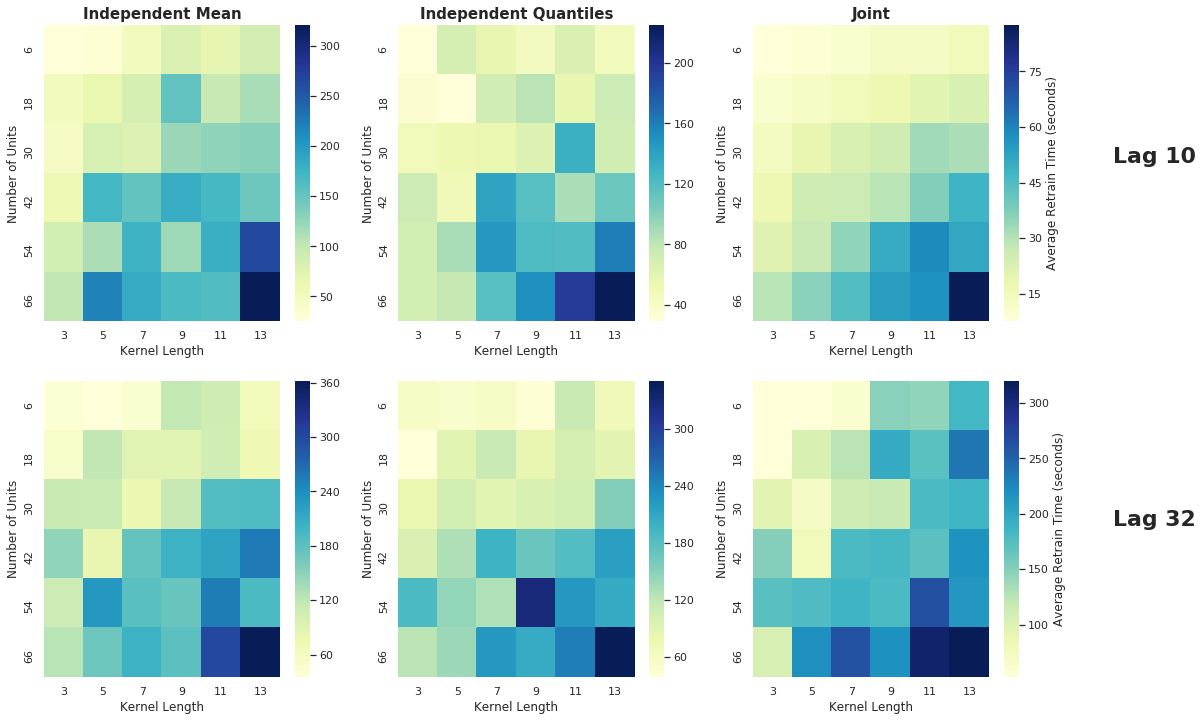

In [0]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'width_ratios':[1.7,1.7,1.7]})
ax1.get_shared_y_axes().join(ax2, ax3)
sns.heatmap(np.mean(time_mean_l10[1:],axis=0), cmap = "YlGnBu", 
            ax=ax1, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)
ax1.set_ylabel('Number of Units')
ax1.set_xlabel('Kernel Length')
ax1.set_title('Independent Mean', fontdict = {'family':'normal','weight':'bold','size':15})
sns.heatmap(np.mean(time_quan_l10[1:],axis=0), cmap = "YlGnBu",  
            ax=ax2, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)
ax2.set_xlabel('Kernel Length')
ax2.set_ylabel('Number of Units')
ax2.set_title('Independent Quantiles', fontdict = {'family':'normal','weight':'bold','size':15})

sns.heatmap(np.mean(time_joint_l10[1:],axis=0), cmap = "YlGnBu", 
            ax=ax3, yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'Average Retrain Time (seconds)'})
bottom, top = ax3.get_ylim()
ax3.set_ylim(bottom + 0.5, top - 0.5)
ax3.set_ylabel('Number of Units')
ax3.set_xlabel('Kernel Length')
ax3.set_title('Joint', fontdict = {'family':'normal','weight':'bold','size':15})

ax4.get_shared_y_axes().join(ax5, ax6)
sns.heatmap(np.mean(time_mean_l32[1:],axis=0), cmap = "YlGnBu", 
            ax=ax4, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax4.get_ylim()
ax4.set_ylim(bottom + 0.5, top - 0.5)
ax4.set_ylabel('Number of Units')
ax4.set_xlabel('Kernel Length')
sns.heatmap(np.mean(time_quan_l32[1:],axis=0), cmap = "YlGnBu",  
            ax=ax5, yticklabels=units_lst, xticklabels=kernel_lengths)
bottom, top = ax5.get_ylim()
ax5.set_ylim(bottom + 0.5, top - 0.5)
ax5.set_xlabel('Kernel Length')
ax5.set_ylabel('Number of Units')

ax6.get_shared_y_axes().join(ax4)
sns.heatmap(np.mean(time_joint_l32[1:],axis=0), cmap = "YlGnBu", 
            ax=ax6, yticklabels=units_lst, xticklabels=kernel_lengths,
            cbar_kws={'label': 'Average Retrain Time (seconds)'})
bottom, top = ax6.get_ylim()
ax6.set_ylim(bottom + 0.5, top - 0.5)
ax6.set_ylabel('Number of Units')
ax6.set_xlabel('Kernel Length')

f.text(0.95, 0.72, "Lag 10", fontdict = {'family' : 'normal','weight' : 'bold','size'   : 22})
f.text(0.95, 0.30, "Lag 32", fontdict = {'family' : 'normal','weight' : 'bold','size'   : 22})

## Assess Best Independent Models on New Partition

In [0]:
part = 3
start_train = start_train_lst[part]
end_train = end_train_lst[part]
end_val = end_test_lst[part]
end_test = end_test_lst[part+1]
print("Training from {} to {}, validation to {} and testing to {}".format(start_train, end_train,end_val, end_test))
ts_train_df, mean_train_df, scale_train_df, ts_val_df, mean_val_df, scale_val_df = load_data(lags, start_train, end_train, end_val)
_, _, _, ts_test_df, mean_test_df, scale_test_df = load_data(lags, start_train, end_val, end_test)

X_train, y_train, y_ix_train, y_mean_train, y_std_train = roll(ts_train_df.index, 
                                                                ts_train_df.values,
                                                                mean_train_df.values,
                                                                scale_train_df.values,
                                                                lags, 
                                                                preds)
X_val, y_val, y_ix_val, y_mean_val, y_std_val = roll(ts_val_df.index, 
                                                      ts_val_df.values, 
                                                      mean_val_df.values,
                                                      scale_val_df.values,
                                                      lags, 
                                                      preds)
X_test, y_test, y_ix_test, y_mean_test, y_std_test = roll(ts_test_df.index, 
                                                          ts_test_df.values, 
                                                          mean_test_df.values,
                                                          scale_test_df.values,
                                                          lags, 
                                                          preds)

X_train = X_train[:,:,:,np.newaxis,np.newaxis]
y_train = y_train[:,:,:,np.newaxis,np.newaxis]
X_val = X_val[:,:,:,np.newaxis,np.newaxis]
y_val = y_val[:,:,:,np.newaxis,np.newaxis]
X_test = X_test[:,:,:,np.newaxis,np.newaxis]
y_test = y_test[:,:,:,np.newaxis,np.newaxis]

Training from 2019-01-14 to 2019-02-14, validation to 2019-02-21 and testing to 2019-03-01


In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
epochs = 200
batch_size = 80

In [0]:
kern = 13
units = 12
check = ModelCheckpoint('best_mean_weights_u{}_k{}_p{}.hdf5'.format(units, kern, part), monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
mod = convLstm(units,kern, lags, num_links, 1, loss = lambda y, f: mse_loss(y, f))
mod.load_weights('best_mean_weights_u{}_k{}_p{}.hdf5'.format(units, kern, part))
history_mean = mod.fit(X_train, y_train, epochs = epochs,validation_data = (X_val, y_val),batch_size = batch_size, callbacks = [es, check],verbose=0)
y_pred = mod.predict(X_test)

Epoch 00013: early stopping


In [0]:
units = 18
kern = 5
y_pred_q = []
for q, quan in enumerate(quantiles):
  check = ModelCheckpoint('best_q{}_weights_u{}_k{}_p{}.hdf5'.format(q, units, kern, part), monitor='val_loss', mode='min', save_best_only=True)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
  mod = convLstm(units,kern, lags, num_links, 1, loss = lambda y, f: tilted_loss(quan, y, f))
  history = mod.fit(X_train, y_train, epochs = epochs,validation_data = (X_val, y_val),batch_size = batch_size, callbacks = [es, check],verbose=0)
  mod.load_weights('best_q{}_weights_u{}_k{}_p{}.hdf5'.format(q, units, kern, part))
  y_pred_q.append(mod.predict(X_test))

Epoch 00077: early stopping
Epoch 00038: early stopping


In [0]:
for lnk in range(num_links):
  q1 = y_pred_q[0][:,0,lnk,0,0]
  q2 = y_pred_q[1][:,0,lnk,0,0]

  print(1 - (np.sum(y_test[:,0,lnk,0,0] < q1) + np.sum(y_test[:,0,lnk,0,0] > q2) )/len(y_test))
  plt.plot(y_ix_test, y_test[:,0,lnk,0,0], 'bo')
  plt.plot(y_ix_test, q1, 'g--')
  plt.plot(y_ix_test, q2, 'g--')
  plt.plot(y_ix_test, y_pred[:,0,lnk,0,0], 'r')
  plt.show()

In [0]:
q1_sum = np.sum(y_pred_q[0][:,0,:,0,0], axis=1)
q2_sum = np.sum(y_pred_q[1][:,0,:,0,0], axis=1)
y_test_sum = np.sum(y_test[:,0,:,0,0], axis=1)
y_pred_sum = np.sum(y_pred[:,0,:,0,0], axis=1)

plt.plot(y_ix_test, y_test_sum, 'bo')
plt.plot(y_ix_test, q1_sum, 'g--', alpha = 0.5)
plt.plot(y_ix_test, q2_sum, 'g--', alpha = 0.5)
plt.plot(y_ix_test, y_pred_sum, 'r')

## Assess selected joint model on new partition

In [0]:
units = 18 
kern = 9
mod_j = joint_convLstm(units, kern, lags, num_links, 1, quantiles, loss = lambda y, f: joint_tilted_loss(quantiles, y, f))

y_traink = np.zeros((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
y_testk  = np.zeros((y_test.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))
y_valk  = np.zeros((y_val.shape[0], y_train.shape[1], y_train.shape[2], 1, len(quantiles)+1))

y_traink[:,:,:,:,0] = y_train[:,:,:,:,0]
y_testk[:,:,:,:,0] = y_test[:,:,:,:,0]
y_valk[:,:,:,:,0] = y_val[:,:,:,:,0]
for i in range(len(quantiles)):
  y_traink[:,:,:,:,i+1] = y_train[:,:,:,:,0]
  y_testk[:,:,:,:,i+1] = y_test[:,:,:,:,0]
  y_valk[:,:,:,:,i+1] = y_val[:,:,:,:,0]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
check_joint = ModelCheckpoint('best_joint_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part), monitor='val_loss', mode='min', save_best_only=True)
history_joint = mod_j.fit(X_train,y_traink, epochs=epochs, validation_data=(X_val, y_valk),batch_size = batch_size,callbacks=[es, check_joint],verbose=1)
mod_j.load_weights('best_joint_weights_a{}_k{}_p{}.hdf5'.format(units, kern, part))

Train on 3061 samples, validate on 747 samples
Epoch 1/200
3061/3061 [==============================] - 13s 4ms/sample - loss: 3.4070 - val_loss: 1.8369
Epoch 2/200
3061/3061 [==============================] - 7s 2ms/sample - loss: 2.9942 - val_loss: 1.6338
Epoch 3/200
3061/3061 [==============================] - 7s 2ms/sample - loss: 2.8303 - val_loss: 1.5385
Epoch 4/200
3061/3061 [==============================] - 7s 2ms/sample - loss: 2.7721 - val_loss: 1.4497
Epoch 5/200
3061/3061 [==============================] - 8s 3ms/sample - loss: 2.7138 - val_loss: 1.4091
Epoch 6/200
3061/3061 [==============================] - 7s 2ms/sample - loss: 2.6682 - val_loss: 1.3809
Epoch 7/200
3061/3061 [==============================] - 7s 2ms/sample - loss: 2.6169 - val_loss: 1.3433
Epoch 8/200
3061/3061 [==============================] - 7s 2ms/sample - loss: 2.5985 - val_loss: 1.3408
Epoch 9/200
3061/3061 [==============================] - 7s 2ms/sample - loss: 2.5747 - val_loss: 1.3122
Epoch 1

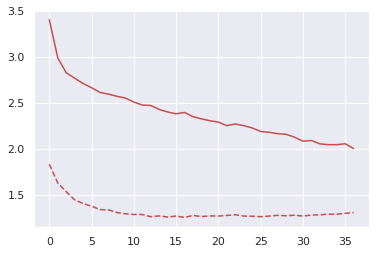

In [0]:
plt.plot(history_joint.history['val_loss'], 'r--')
plt.plot(history_joint.history['loss'], 'r')

In [0]:
y_pred = mod_j.predict(X_test)
Y_pred_mean = y_pred[:,:,:,0,0]
Y_pred_lwr  = y_pred[:,:,:,0,1]
Y_pred_upr  = y_pred[:,:,:,0,2]

0.8720657276995305


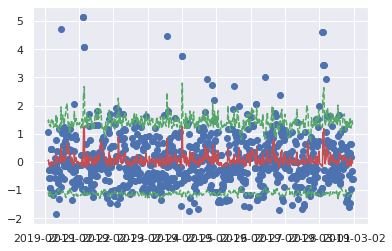

0.8392018779342723


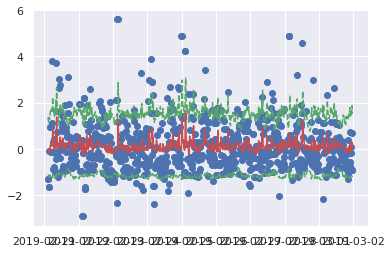

0.903755868544601


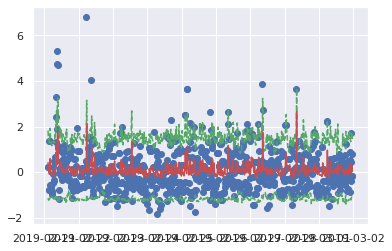

0.812206572769953


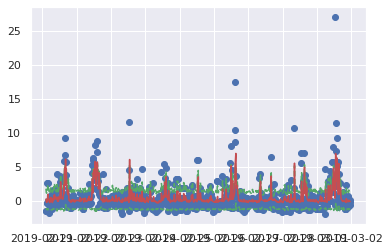

0.8650234741784038


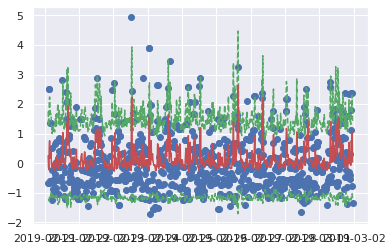

0.8779342723004695


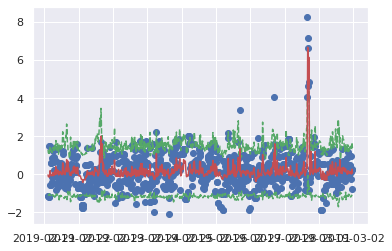

0.8650234741784038


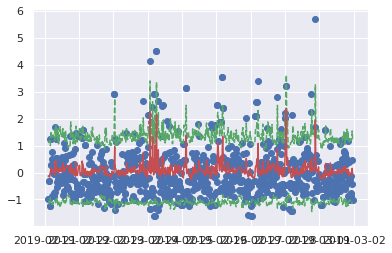

0.8896713615023474


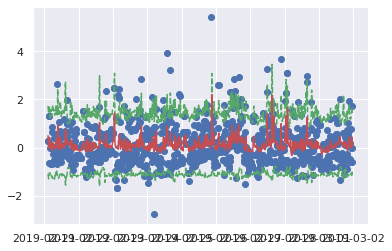

0.9272300469483568


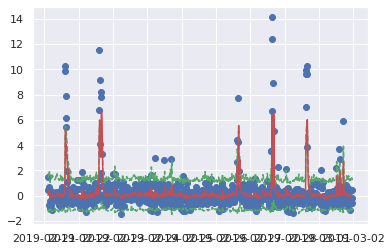

0.9143192488262911


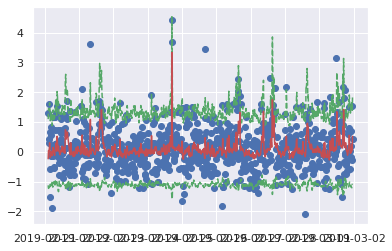

0.823943661971831


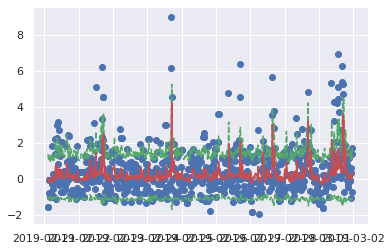

0.8497652582159625


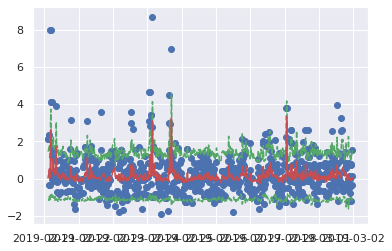

0.8650234741784038


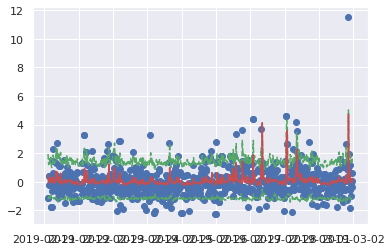

0.8591549295774648


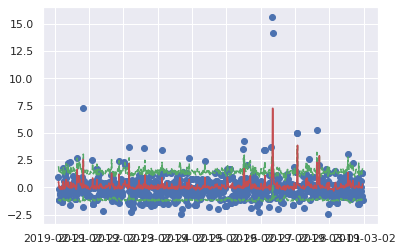

0.8791079812206573


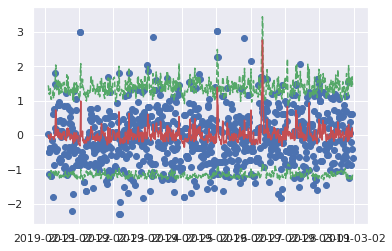

0.8591549295774648


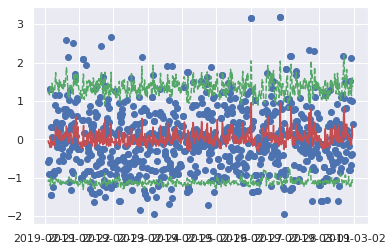

In [0]:
for lnk in range(num_links):
  q1 = y_pred[:,0,lnk,0,1]
  q2 = y_pred[:,0,lnk,0,2]

  print(1 - (np.sum(y_test[:,0,lnk,0,0] < q1) + np.sum(y_test[:,0,lnk,0,0] > q2) )/len(y_test))
  plt.plot(y_ix_test, y_test[:,0,lnk,0,0], 'bo')
  plt.plot(y_ix_test, q1, 'g--')
  plt.plot(y_ix_test, q2, 'g--')
  plt.plot(y_ix_test, y_pred[:,0,lnk,0,0], 'r')
  plt.show()

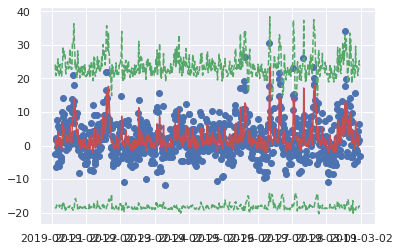

In [0]:
q1 = np.sum(y_pred[:,0,:,0,1], axis=1)
q2 = np.sum(y_pred[:,0,:,0,2], axis=1)
plt.plot(y_ix_test, np.sum(y_test[:,0,:,0,0],axis=1), 'bo')
plt.plot(y_ix_test, q1, 'g--')
plt.plot(y_ix_test, q2, 'g--')
plt.plot(y_ix_test, np.sum(y_pred[:,0,:,0,0],axis=1), 'r')
plt.show()